In [18]:
from astropy.io import fits
from specutils import Spectrum1D
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u
import requests
from io import BytesIO
import os

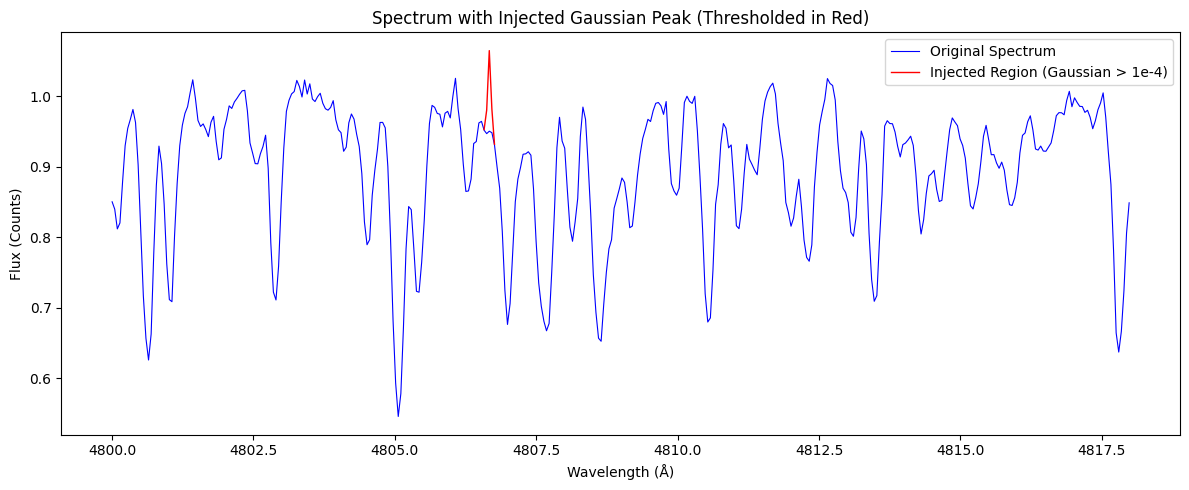

In [13]:

# === Open FITS file from local path ===
hdul = fits.open('/home/emmay/BL2025/161116001701343.fits')

# === Read PRIMARY HDU ===
header = hdul[0].header
flux = hdul[0].data.astype(float)

# === Build wavelength axis ===
crval1 = header.get('CRVAL1')
cdelt1 = header.get('CDELT1')
crpix1 = header.get('CRPIX1', 1)

if crval1 is None or cdelt1 is None:
    raise ValueError("Missing CRVAL1 or CDELT1 in FITS header")

npix = len(flux)
wavelength = (crval1 + (np.arange(npix) + 1 - crpix1) * cdelt1) * u.AA

# === Inject Gaussian Peak ===
fwhm = 1.5  # pixels
sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
center = npix // 2

x = np.arange(npix)
gaussian = np.exp(-0.5 * ((x - center) / sigma) ** 2)
gaussian *= 0.1 * np.nanmax(flux)  # scale to 10% of max flux

flux_injected = flux + gaussian

# === Define zoomed wavelength window ===
wl_start = 4800  # Å
wl_end = 4818    # Å

mask = (wavelength.value >= wl_start) & (wavelength.value <= wl_end)
wave_zoom = wavelength[mask]
flux_orig_zoom = flux[mask]
flux_inj_zoom = flux_injected[mask]
gaussian_zoom = gaussian[mask]

# === Mask for where Gaussian > 1e-4 ===
threshold_mask = gaussian_zoom > 1e-4

# === Plot ===
plt.figure(figsize=(12, 5))

# Plot original spectrum (blue, full)
plt.plot(wave_zoom, flux_orig_zoom, color='blue', linewidth=0.8, label="Original Spectrum")

# Plot injected spectrum only where Gaussian > 1e-4 (red)
plt.plot(wave_zoom[threshold_mask], flux_inj_zoom[threshold_mask],
         color='red', linewidth=1.0, label="Injected Region (Gaussian > 1e-4)")

plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux (Counts)")
plt.title("Spectrum with Injected Gaussian Peak (Thresholded in Red)")
plt.legend()
plt.tight_layout()
plt.show()


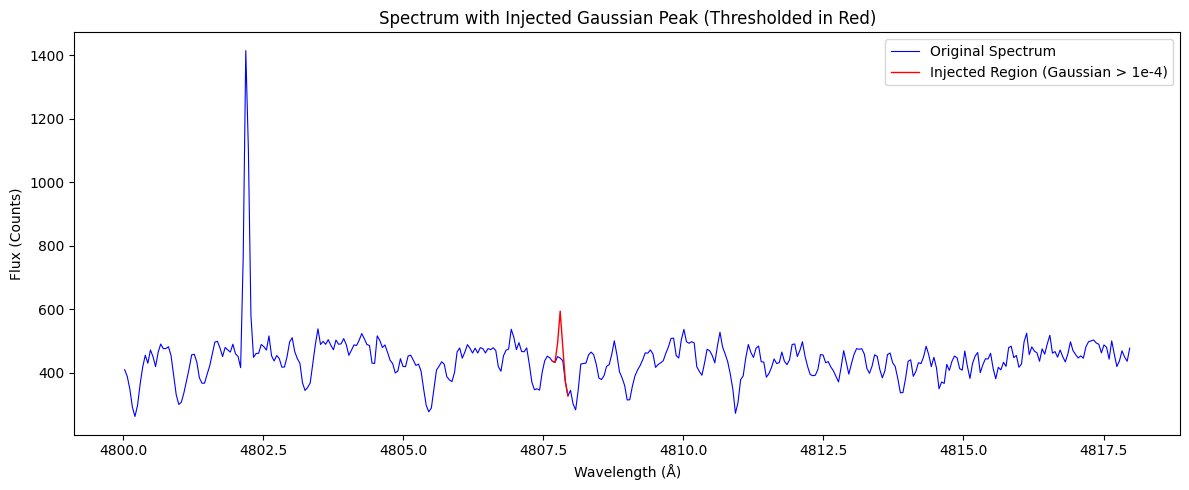

In [22]:

# === Open FITS file from local path ===
hdul = fits.open('/datax/scratch/emmay/galah_spectra/140708007101168_B.fits')

# === Read PRIMARY HDU ===
header = hdul[0].header
flux = hdul[0].data.astype(float)

# === Build wavelength axis ===
crval1 = header.get('CRVAL1')
cdelt1 = header.get('CDELT1')
crpix1 = header.get('CRPIX1', 1)

if crval1 is None or cdelt1 is None:
    raise ValueError("Missing CRVAL1 or CDELT1 in FITS header")

npix = len(flux)
wavelength = (crval1 + (np.arange(npix) + 1 - crpix1) * cdelt1) * u.AA

# === Inject Gaussian Peak ===
fwhm = 1.5  # pixels
sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
center = npix // 2

x = np.arange(npix)
gaussian = np.exp(-0.5 * ((x - center) / sigma) ** 2)
gaussian *= 0.1 * np.nanmax(flux)  # scale to 10% of max flux

flux_injected = flux + gaussian

# === Define zoomed wavelength window ===
wl_start = 4800  # Å
wl_end = 4818    # Å

mask = (wavelength.value >= wl_start) & (wavelength.value <= wl_end)
wave_zoom = wavelength[mask]
flux_orig_zoom = flux[mask]
flux_inj_zoom = flux_injected[mask]
gaussian_zoom = gaussian[mask]

# === Mask for where Gaussian > 1e-4 ===
threshold_mask = gaussian_zoom > 1e-4

# === Plot ===
plt.figure(figsize=(12, 5))

# Plot original spectrum (blue, full)
plt.plot(wave_zoom, flux_orig_zoom, color='blue', linewidth=0.8, label="Original Spectrum")

# Plot injected spectrum only where Gaussian > 1e-4 (red)
plt.plot(wave_zoom[threshold_mask], flux_inj_zoom[threshold_mask],
         color='red', linewidth=1.0, label="Injected Region (Gaussian > 1e-4)")

plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux (Counts)")
plt.title("Spectrum with Injected Gaussian Peak (Thresholded in Red)")
plt.legend()
plt.tight_layout()
plt.show()


## Plot Lasers for 10 Downloaded Spectra

In [23]:
def inject_and_plot_laser(obj_id, filt, folder="/datax/scratch/emmay/galah_spectra",
                          fwhm=1.5, laser_amp_percent=10, plot=True):
    """
    Injects a Gaussian laser spike into GALAH FITS spectrum and plots it.

    Parameters:
        obj_id (str): Object ID
        filt (str): Filter (e.g. 'B', 'V', 'R', 'I')
        folder (str): Path to FITS files
        fwhm (float): FWHM of the Gaussian in pixels
        laser_amp_percent (float): Amplitude of injection as percentage of max flux
        plot (bool): Whether to show the plot

    Returns:
        wavelength (np.ndarray): Wavelength array (in Å)
        flux_injected (np.ndarray): Flux array with injected Gaussian
    """
    filename = f"{obj_id}_{filt}.fits"
    path = os.path.join(folder, filename)

    with fits.open(path) as hdul:
        header = hdul[1].header
        flux = hdul[1].data.astype(float)

    # Build wavelength axis
    crval1 = header.get('CRVAL1')
    cdelt1 = header.get('CDELT1')
    crpix1 = header.get('CRPIX1', 1)

    npix = len(flux)
    wavelength = (crval1 + (np.arange(npix) + 1 - crpix1) * cdelt1) * u.AA

    # Inject Gaussian
    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
    center = npix // 2
    x = np.arange(npix)
    gaussian = np.exp(-0.5 * ((x - center) / sigma) ** 2)
    gaussian *= (laser_amp_percent / 100.0) * np.nanmax(flux)

    flux_injected = flux + gaussian

    # Plot
    if plot:
        threshold_mask = gaussian > 1e-4
        plt.figure(figsize=(13, 5))
        plt.plot(wavelength, flux, color='blue', linewidth=0.6, label="Original Spectrum")
        plt.plot(wavelength[threshold_mask], flux_injected[threshold_mask], color='red', linewidth=1.0, label="Injected Region")
        plt.xlabel("Wavelength (Å)")
        plt.ylabel("Flux")
        plt.title(f"Injected Spectrum — {obj_id} ({filt}) — Amplitude = {laser_amp_percent}%")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return wavelength.value, flux_injected


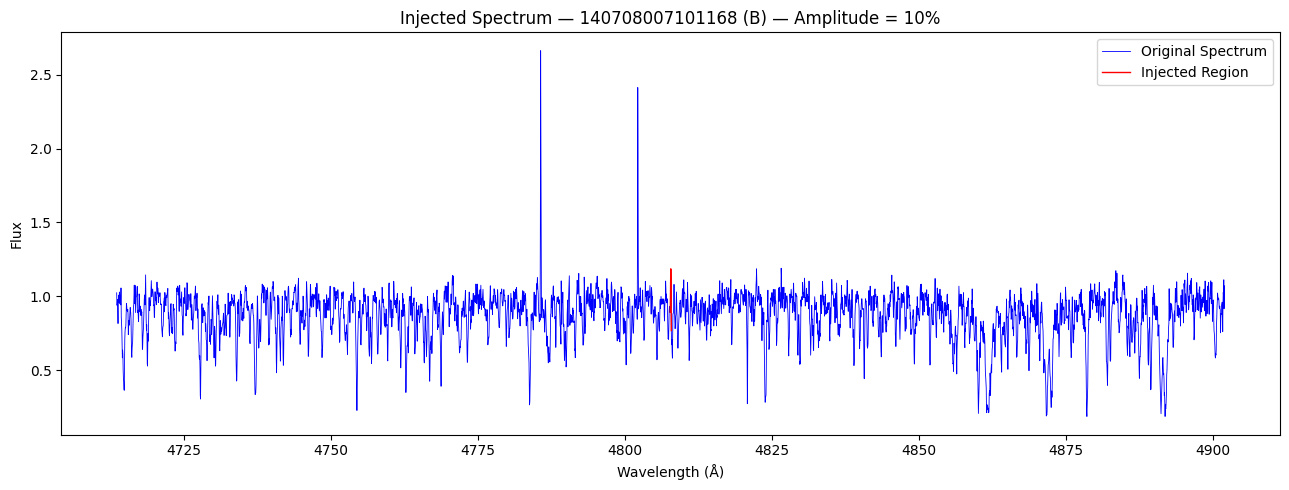

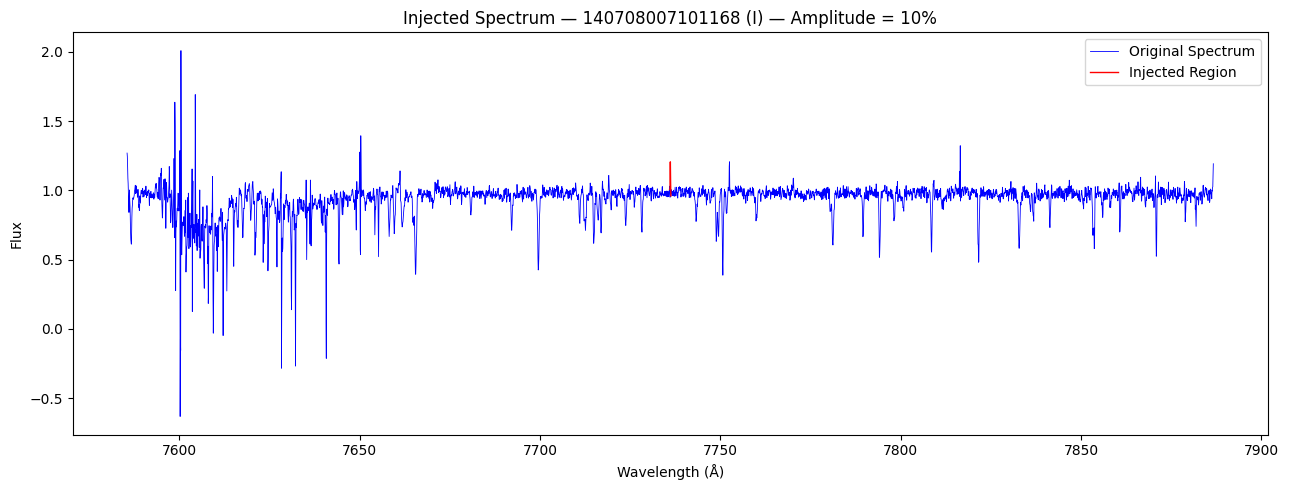

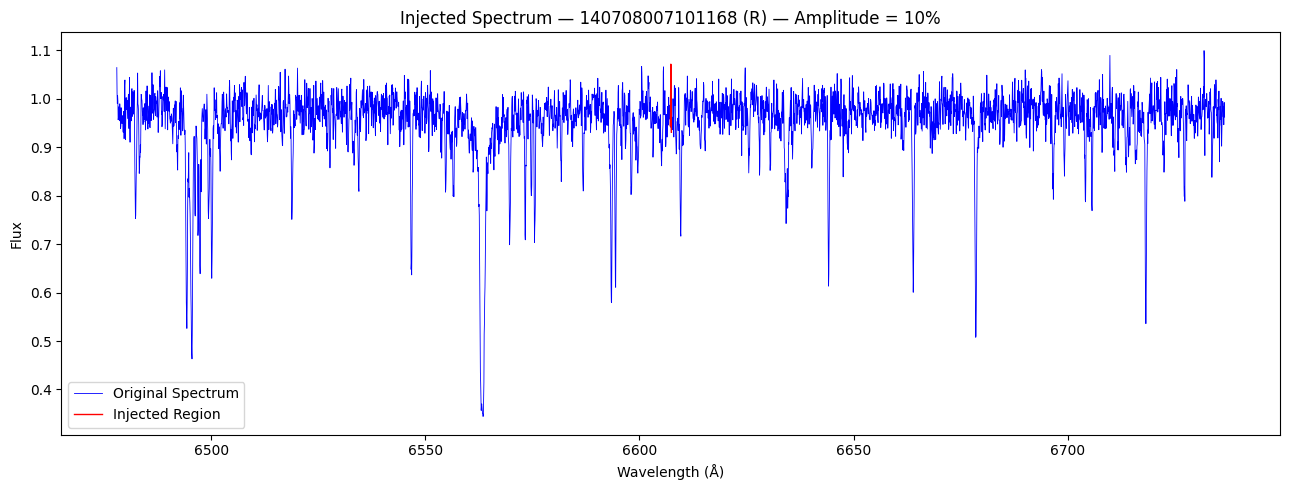

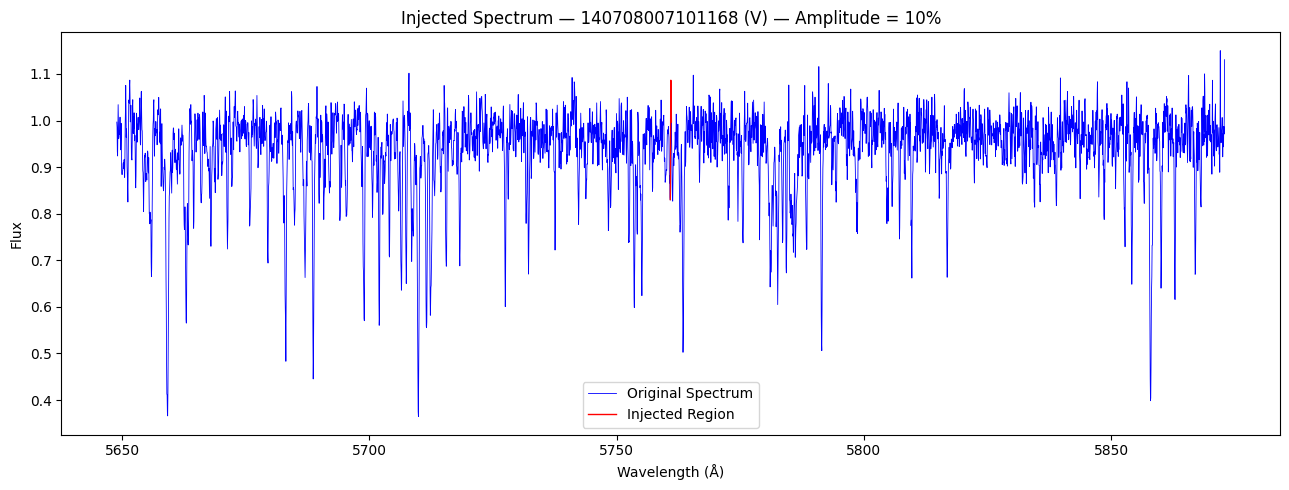

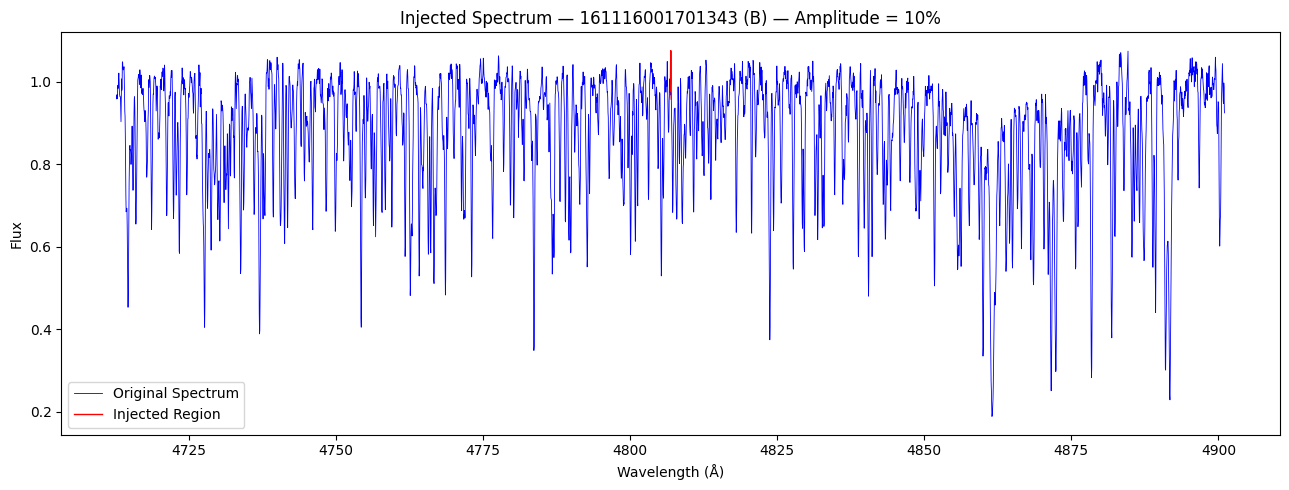

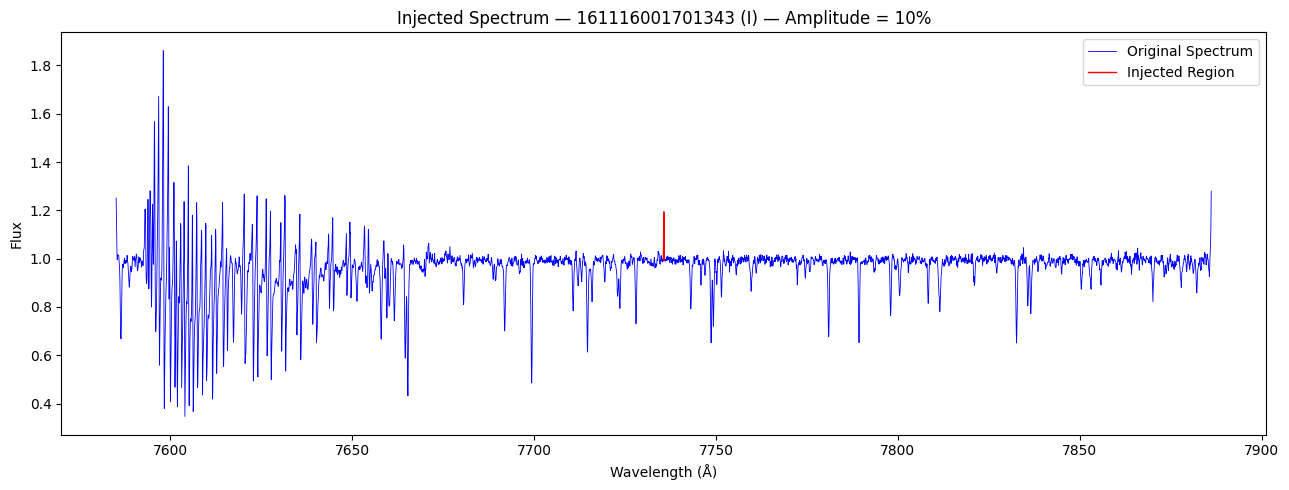

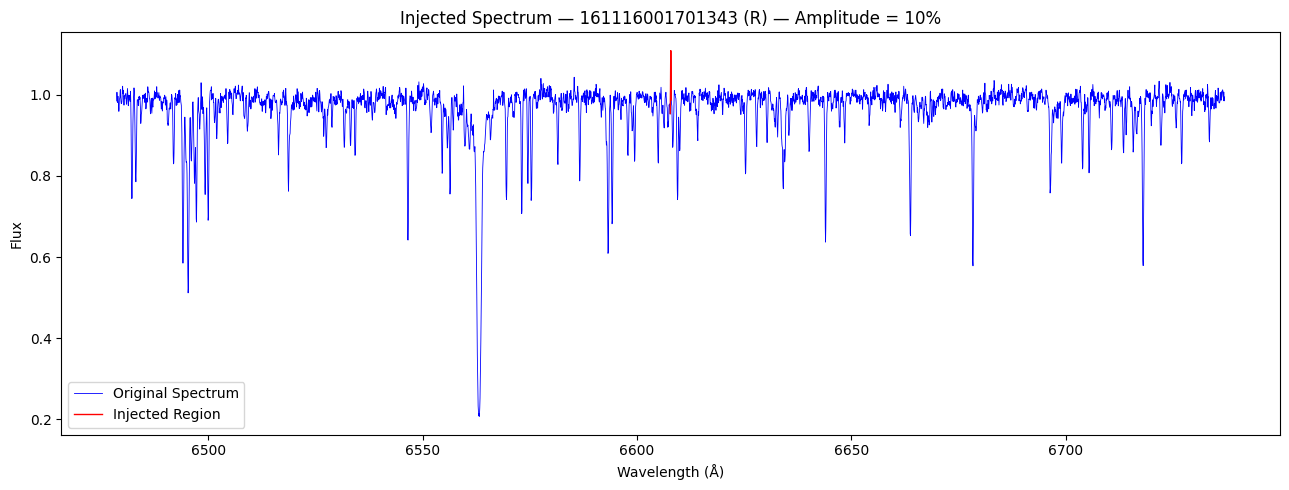

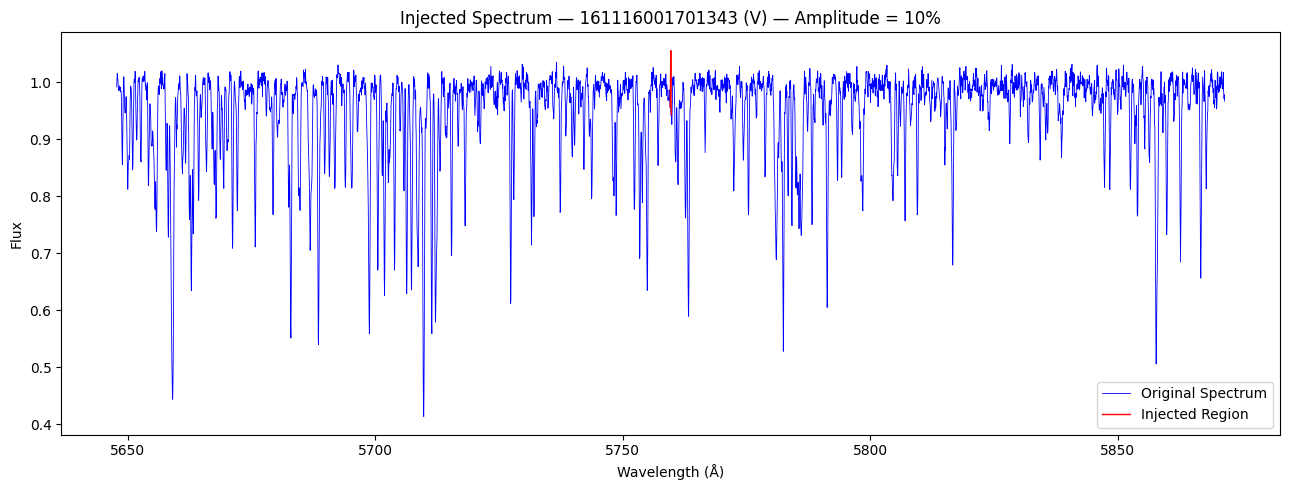

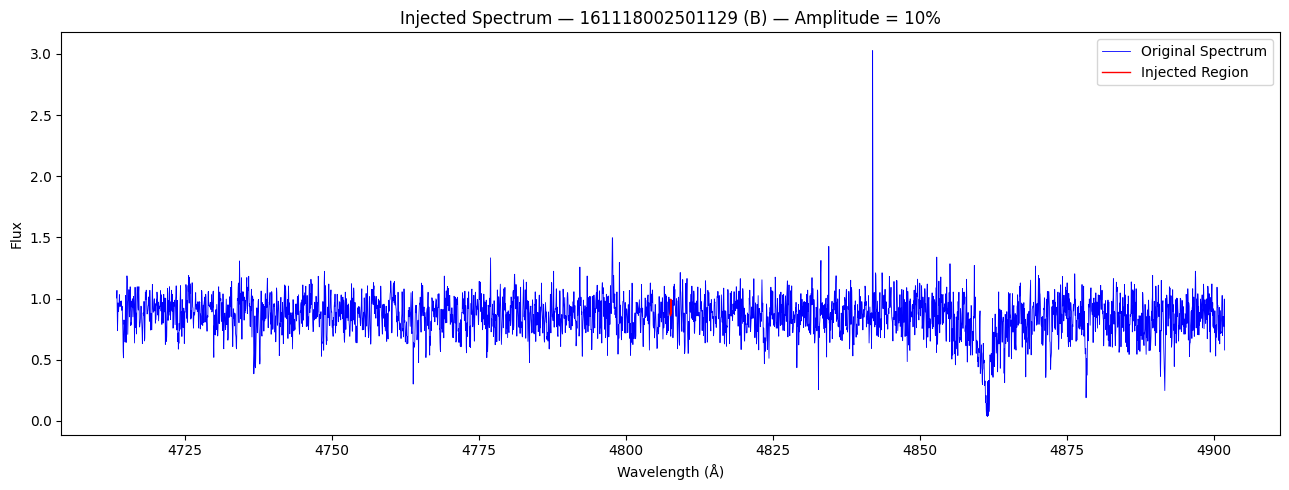

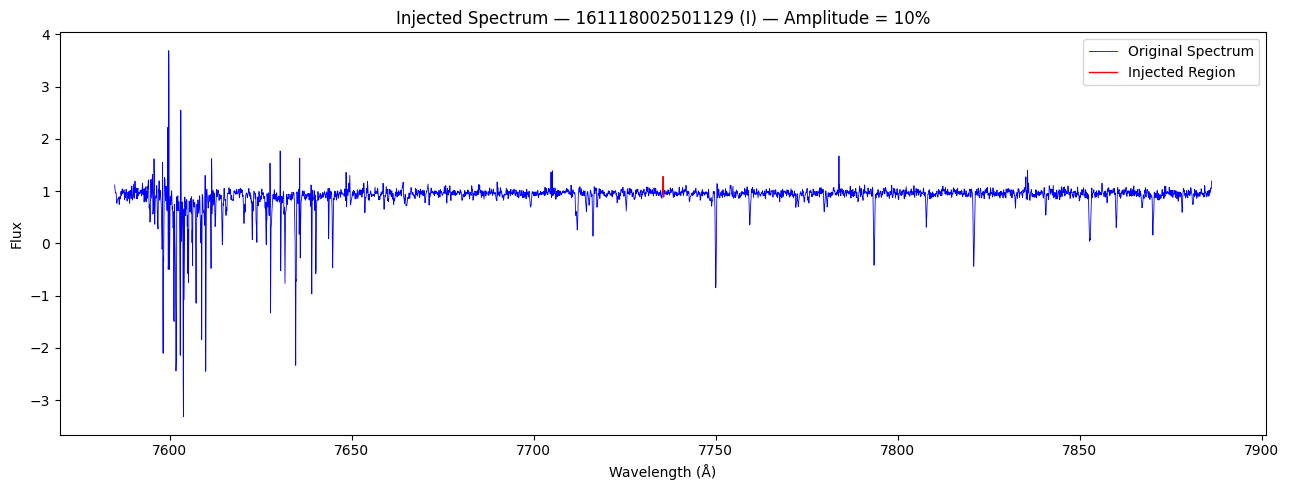

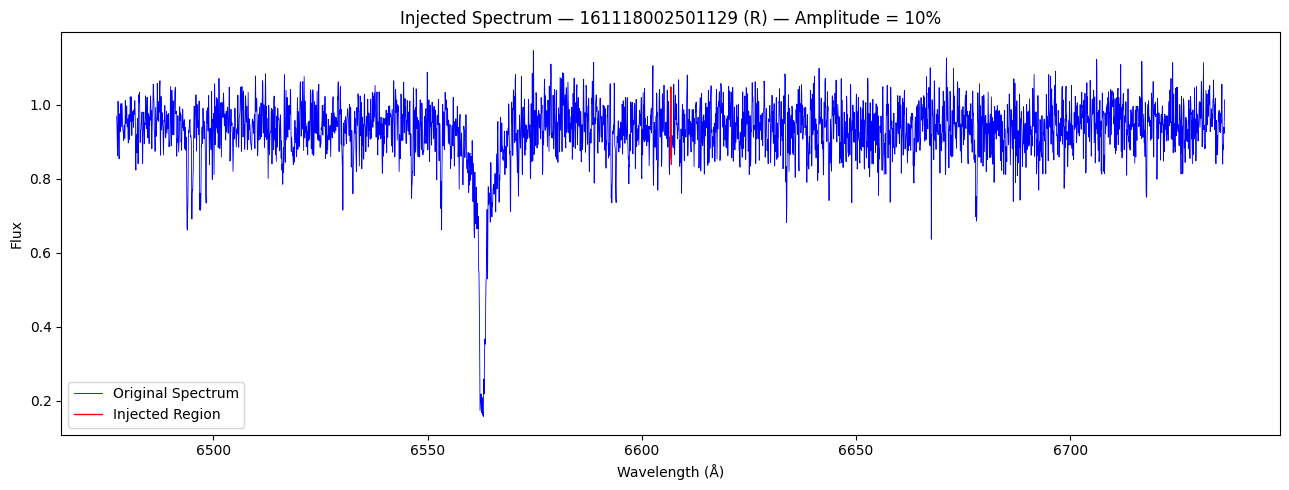

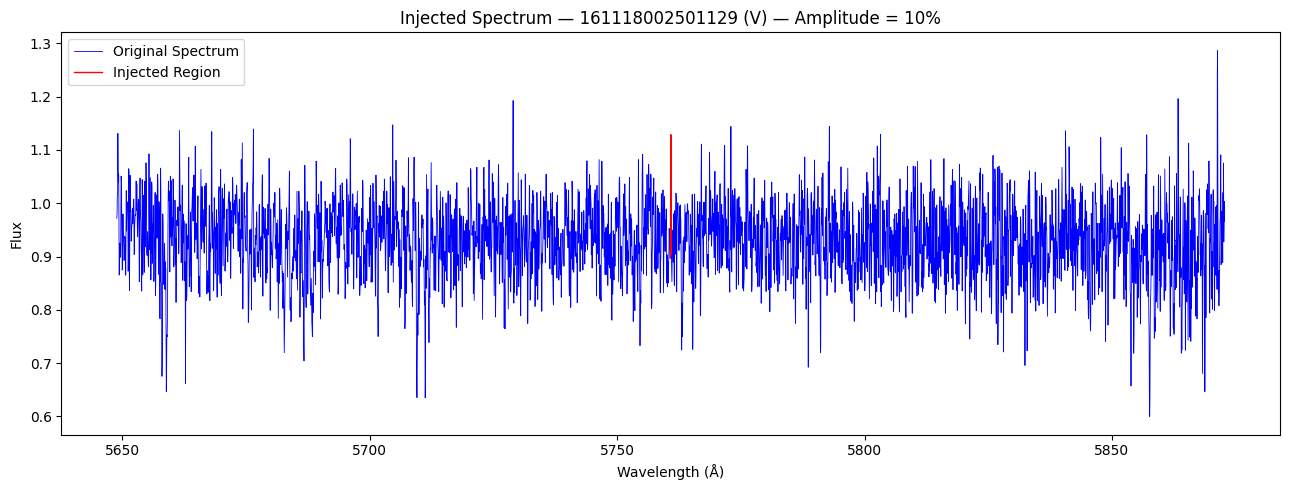

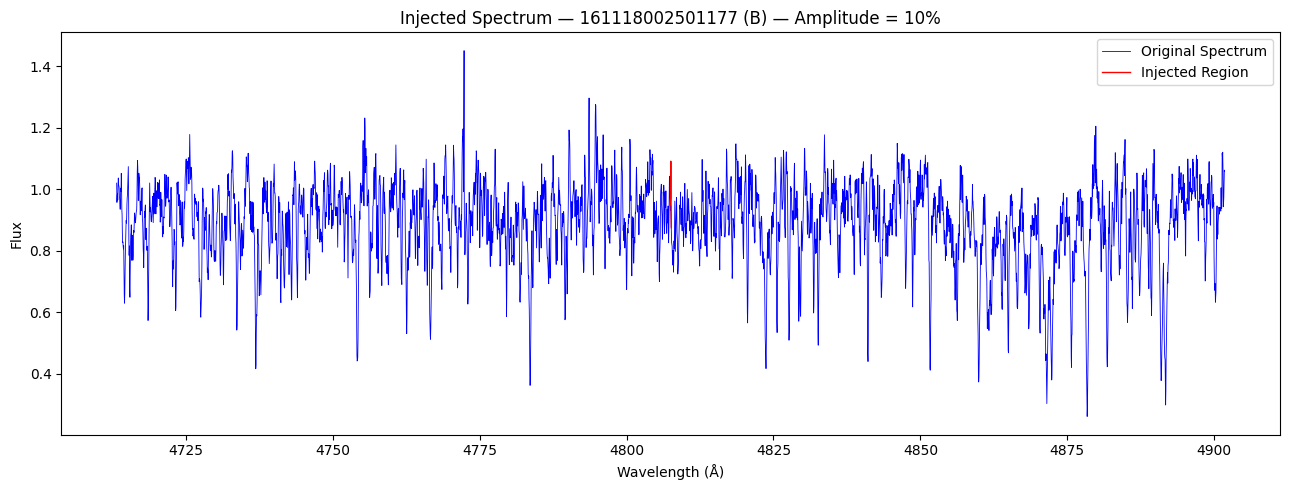

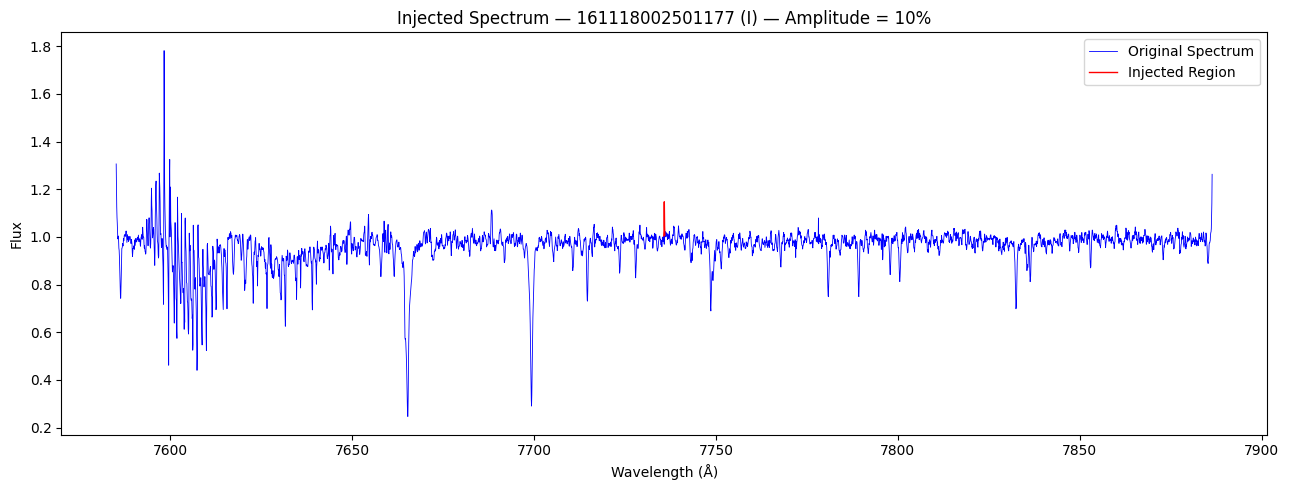

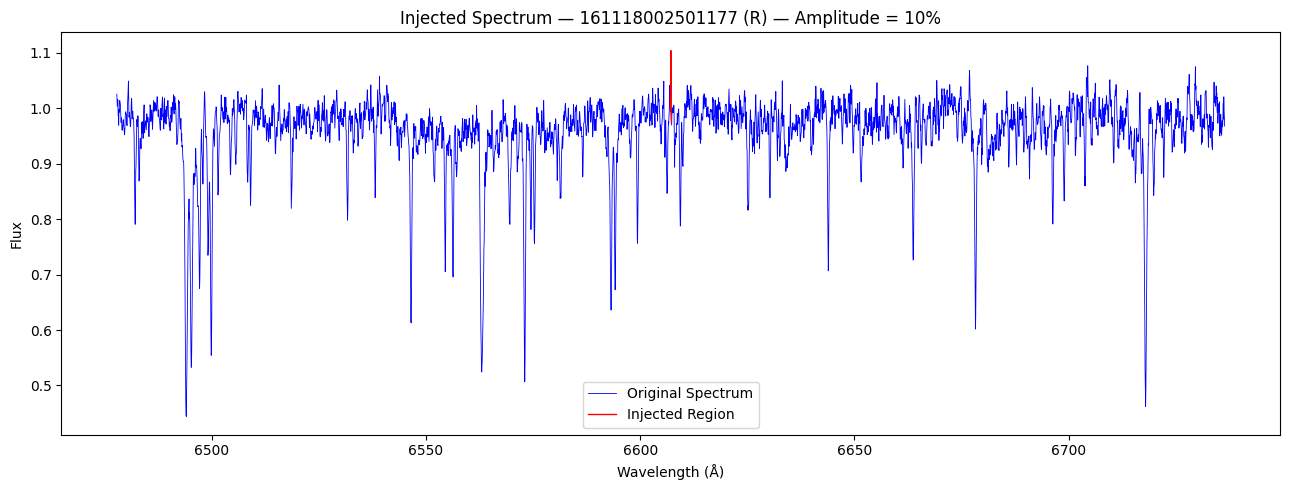

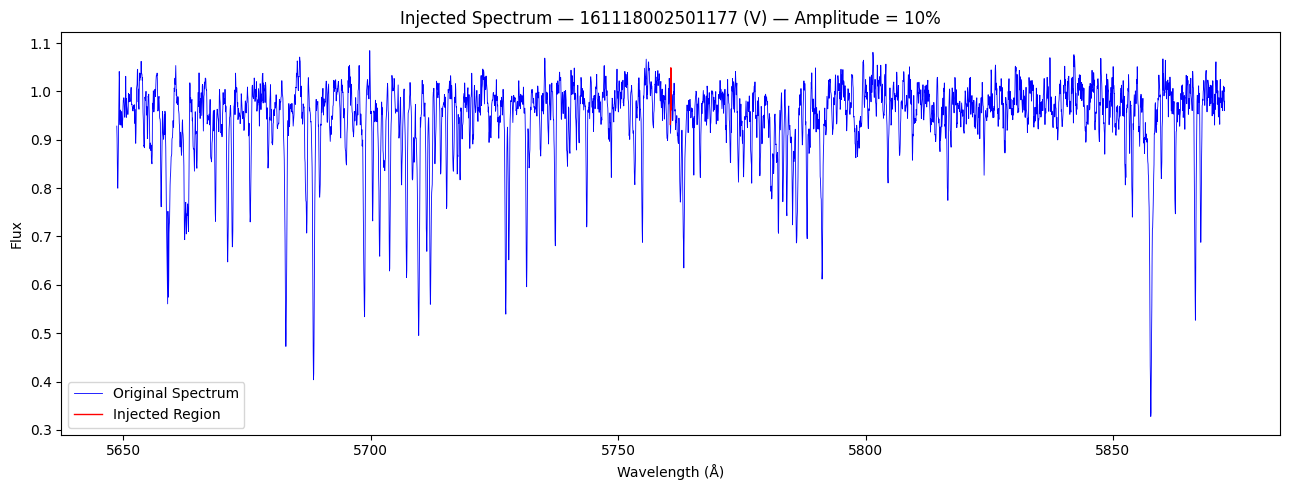

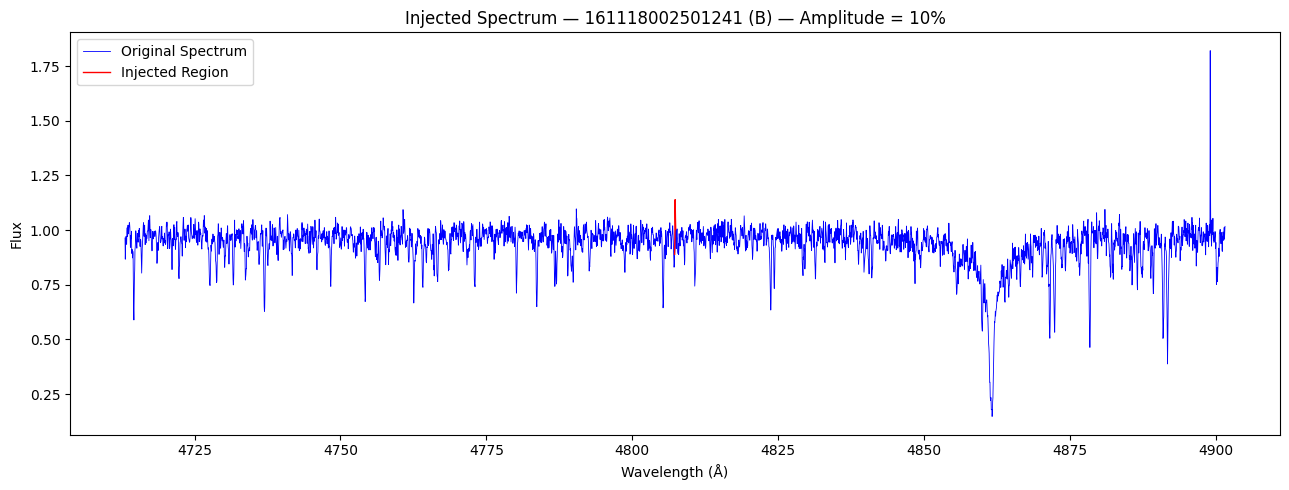

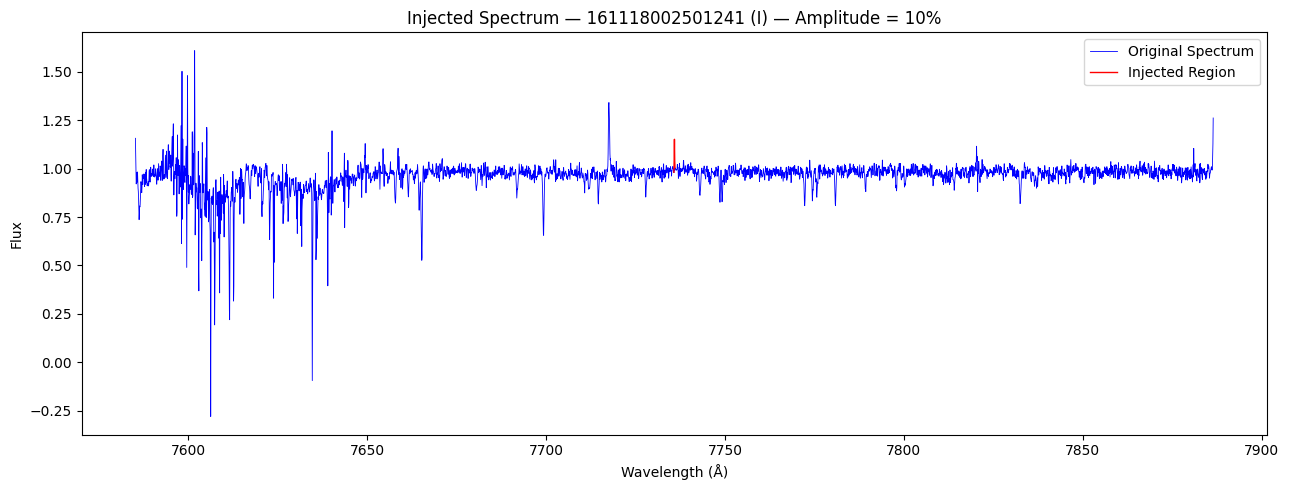

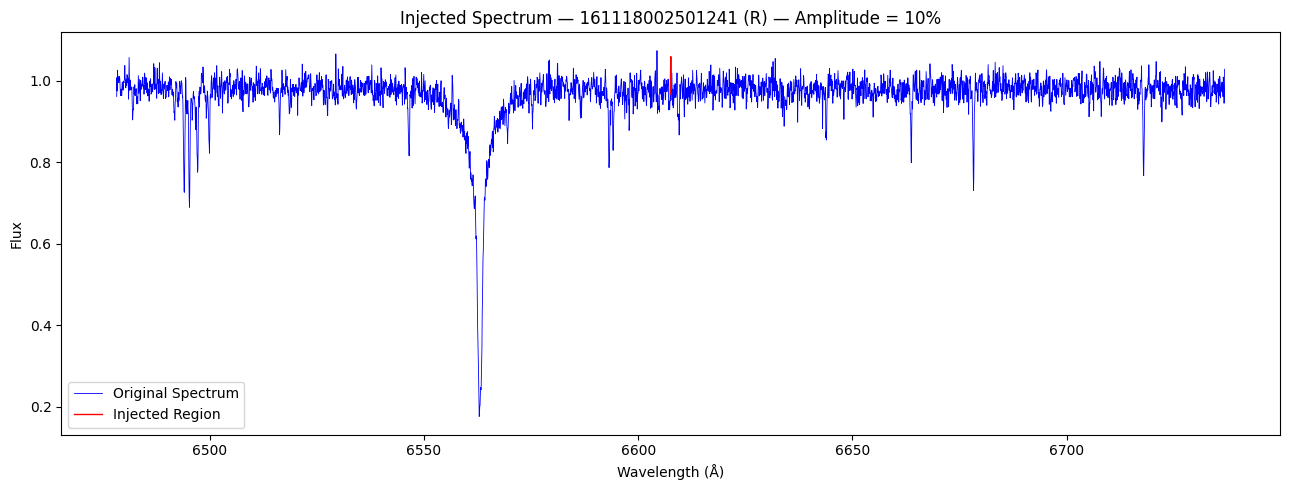

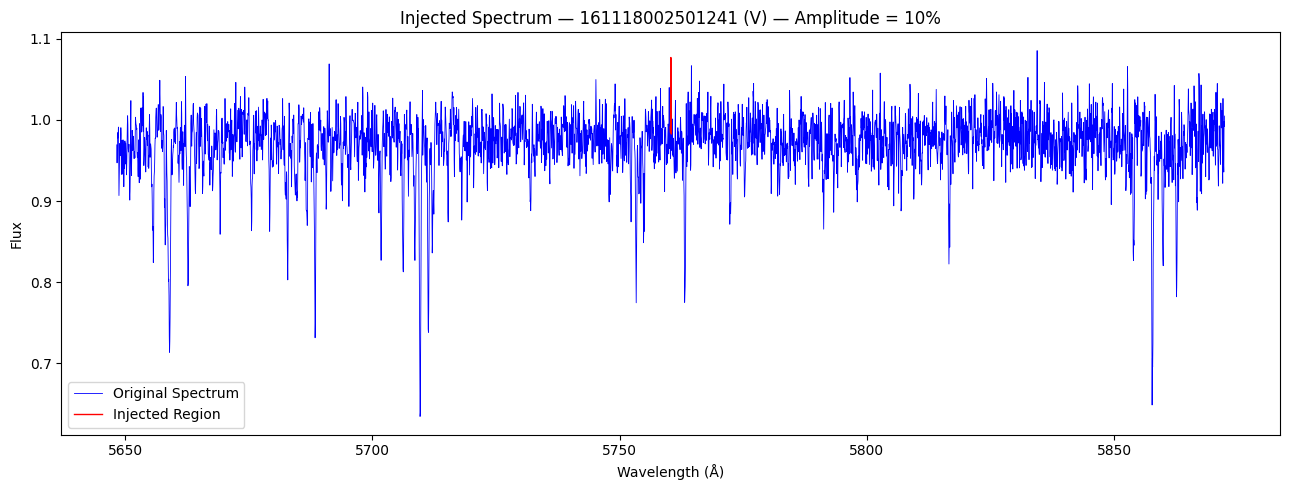

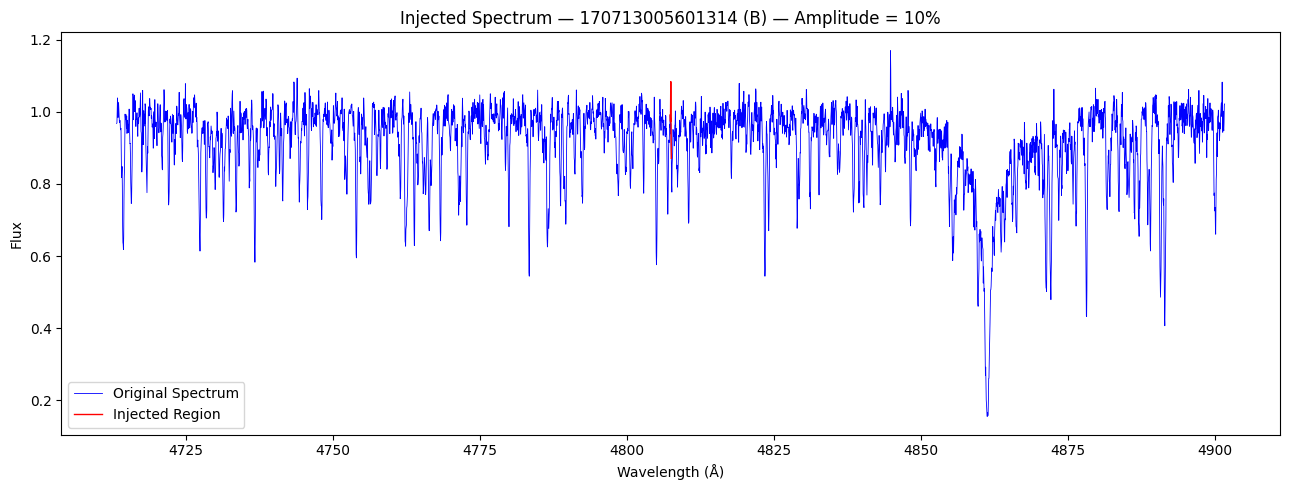

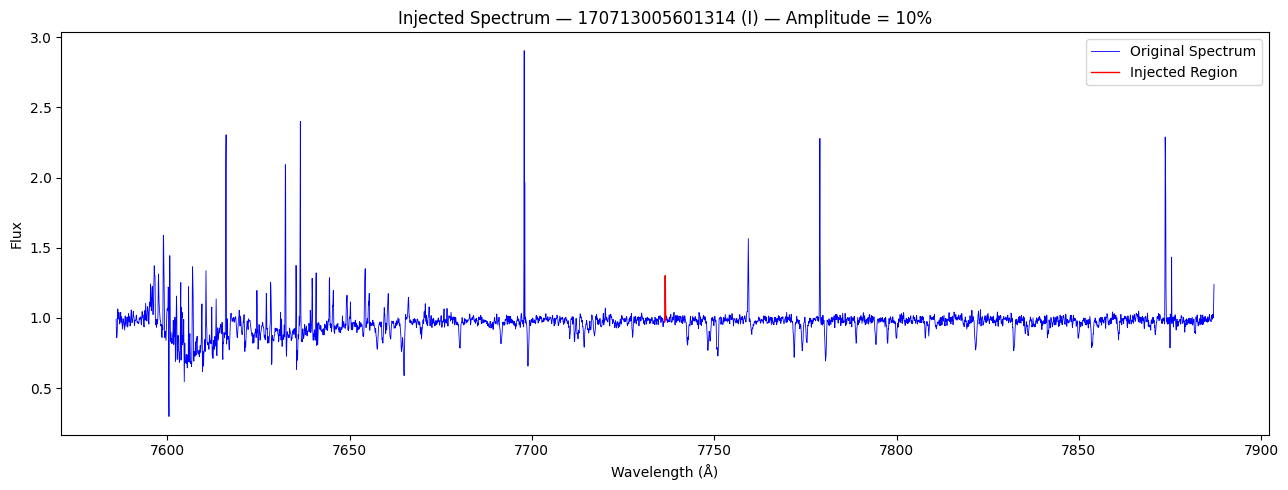

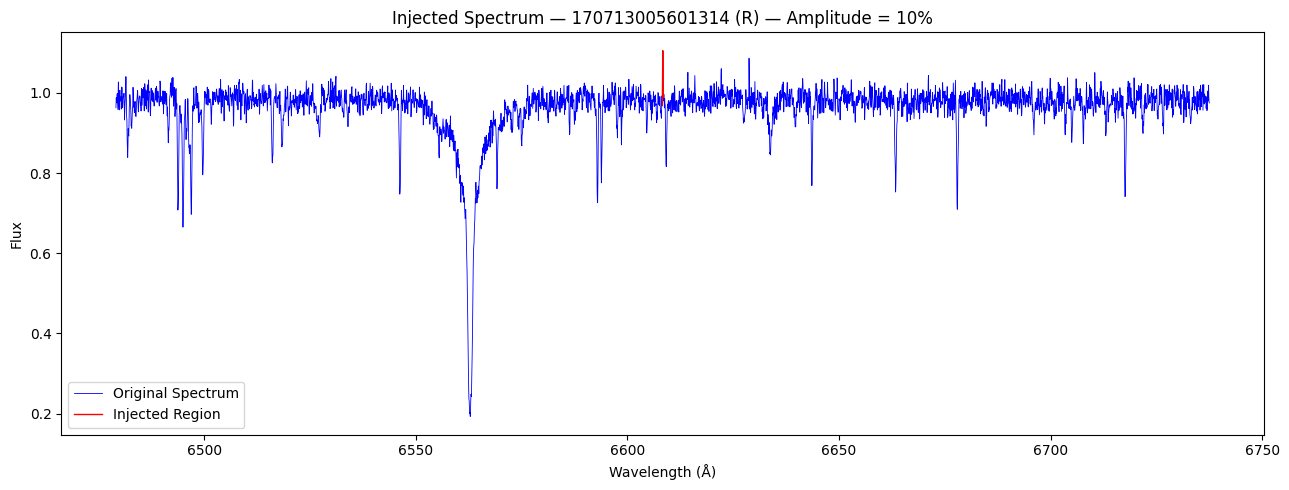

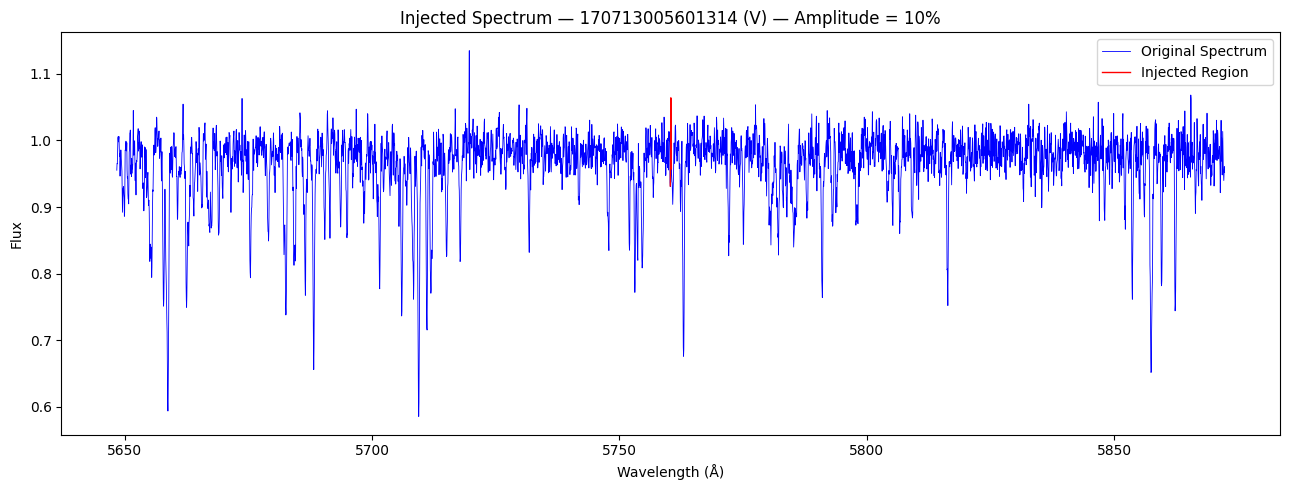

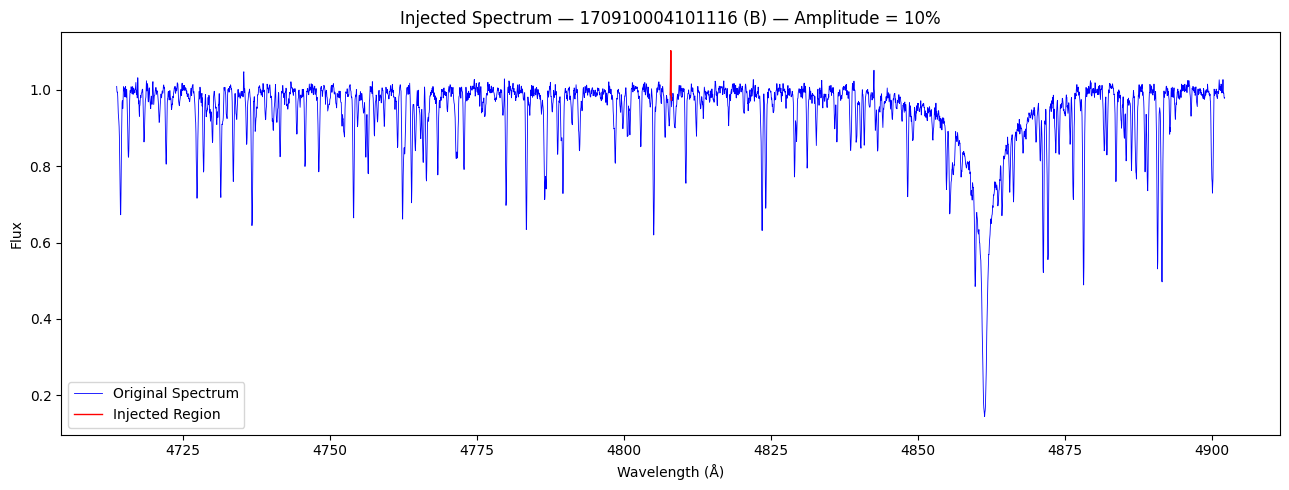

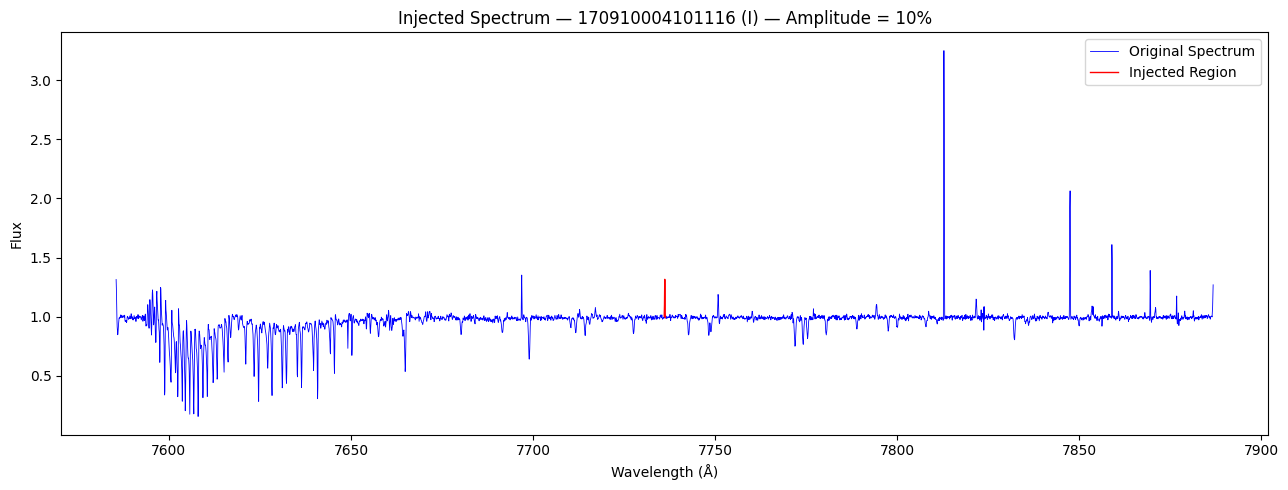

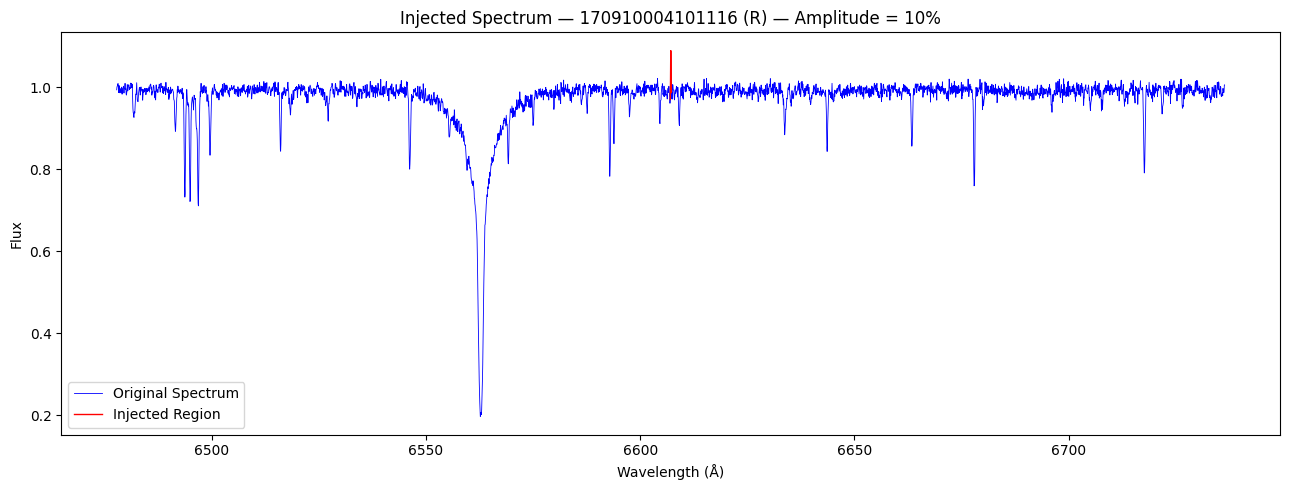

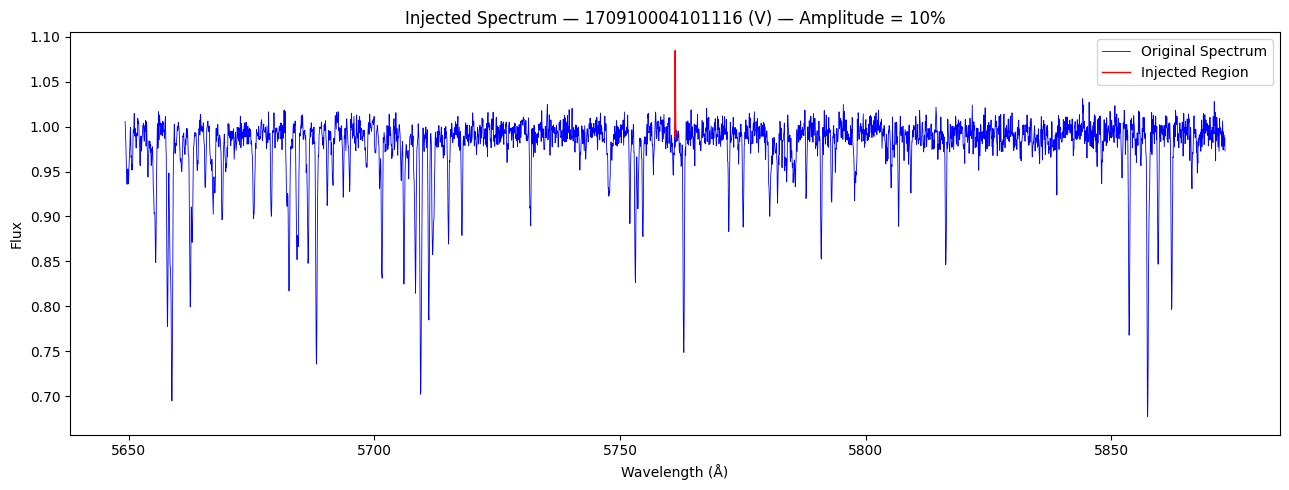

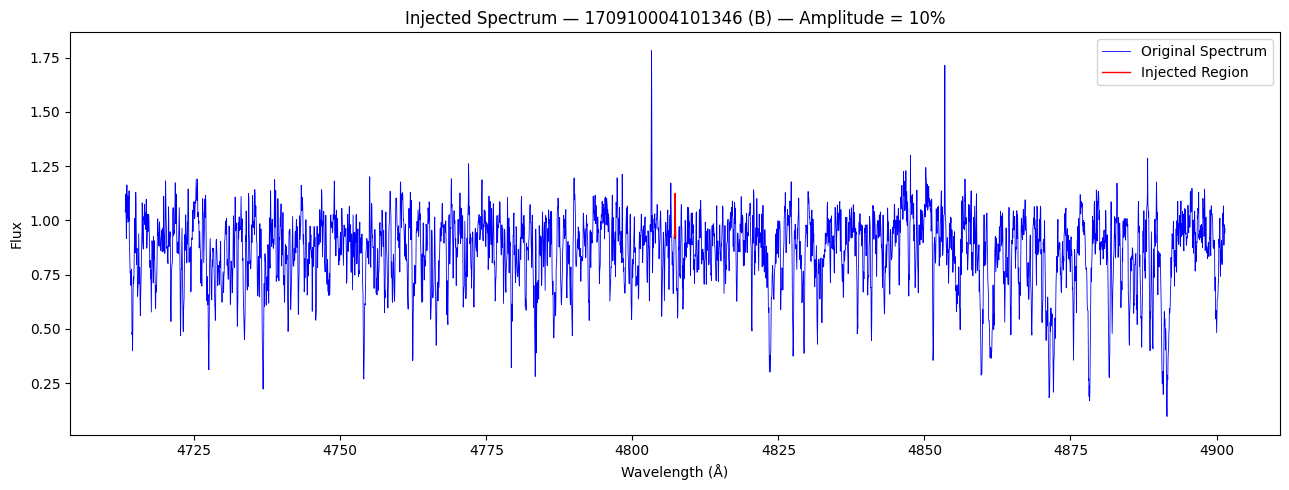

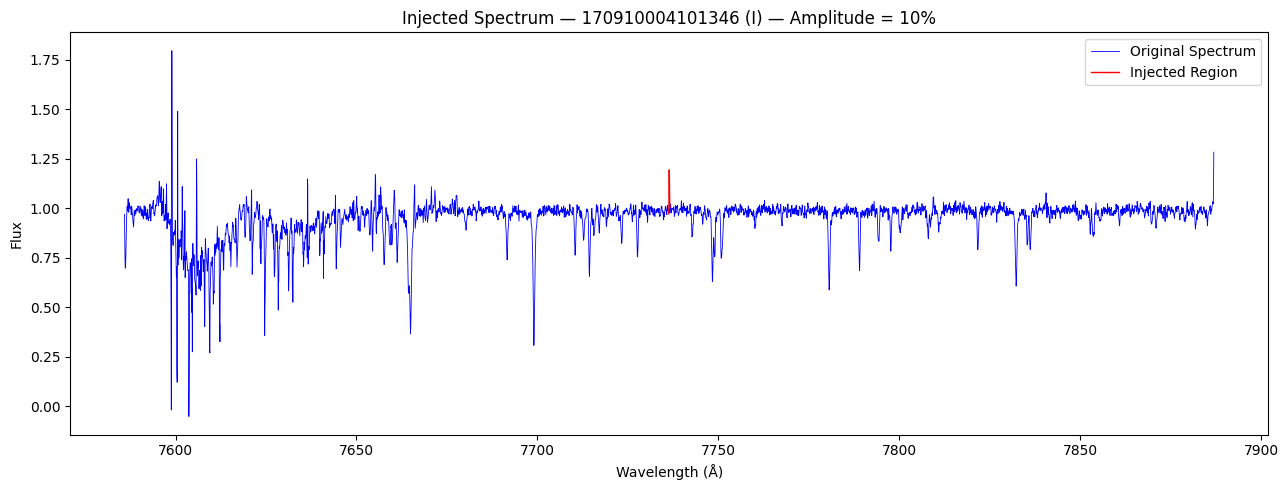

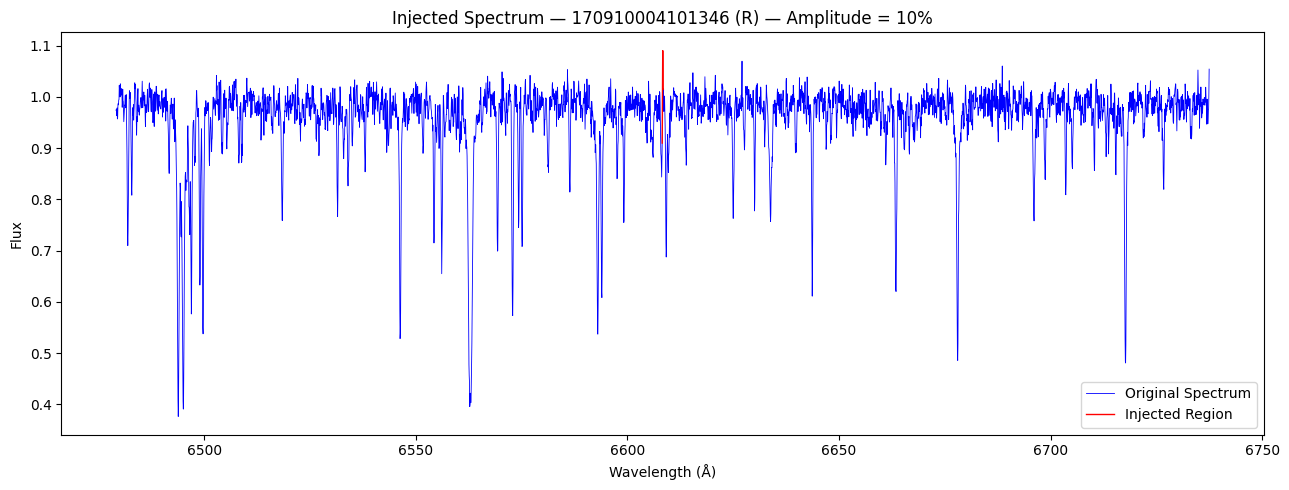

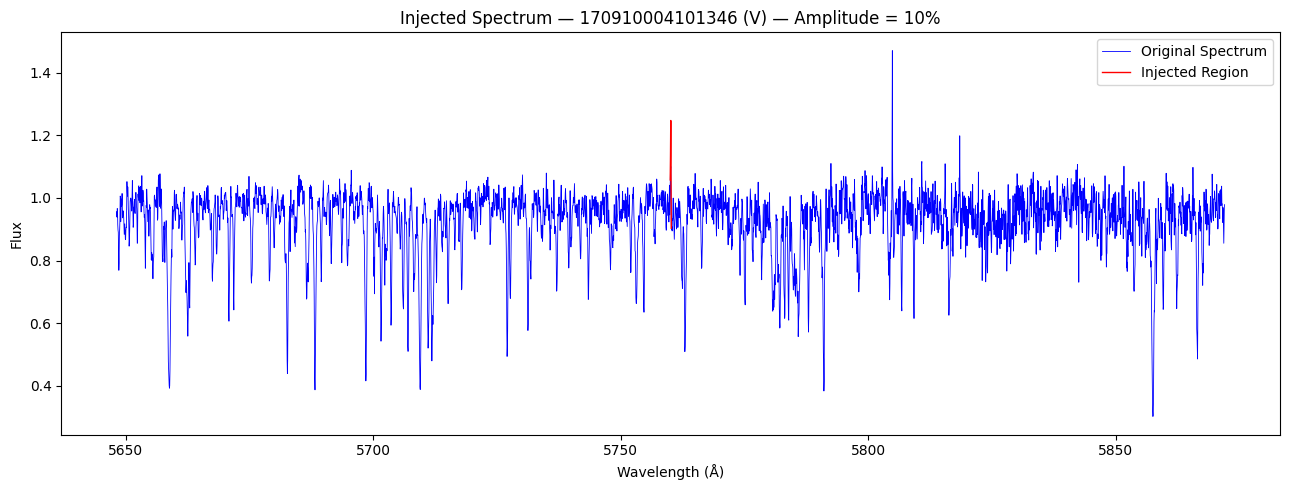

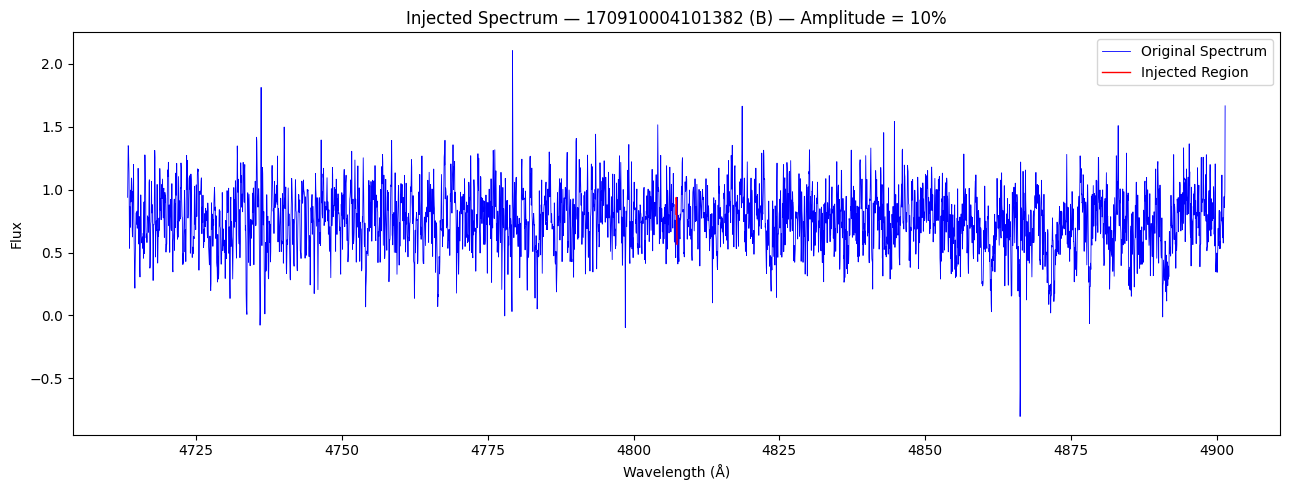

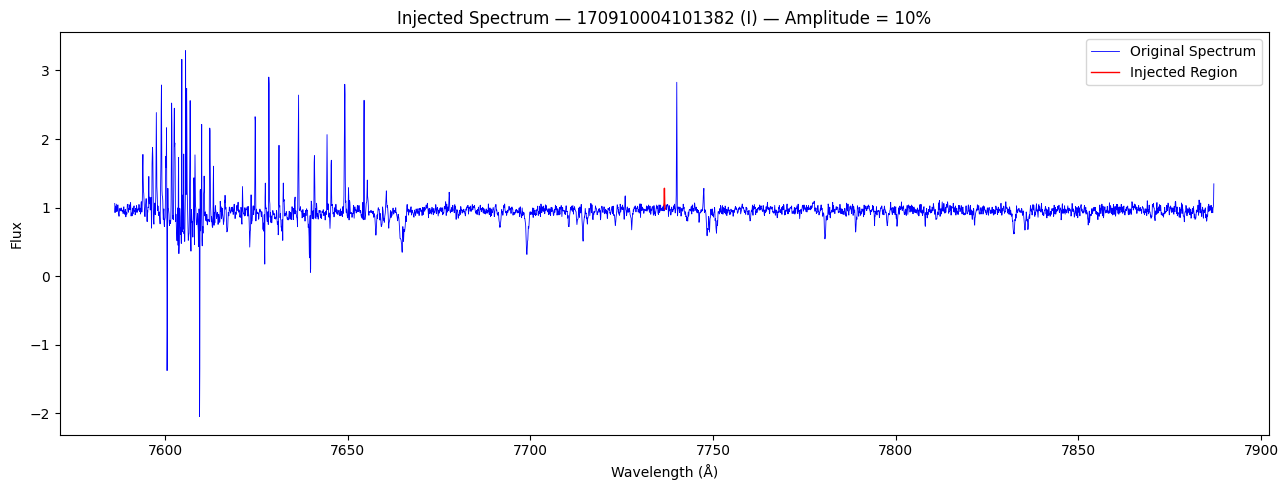

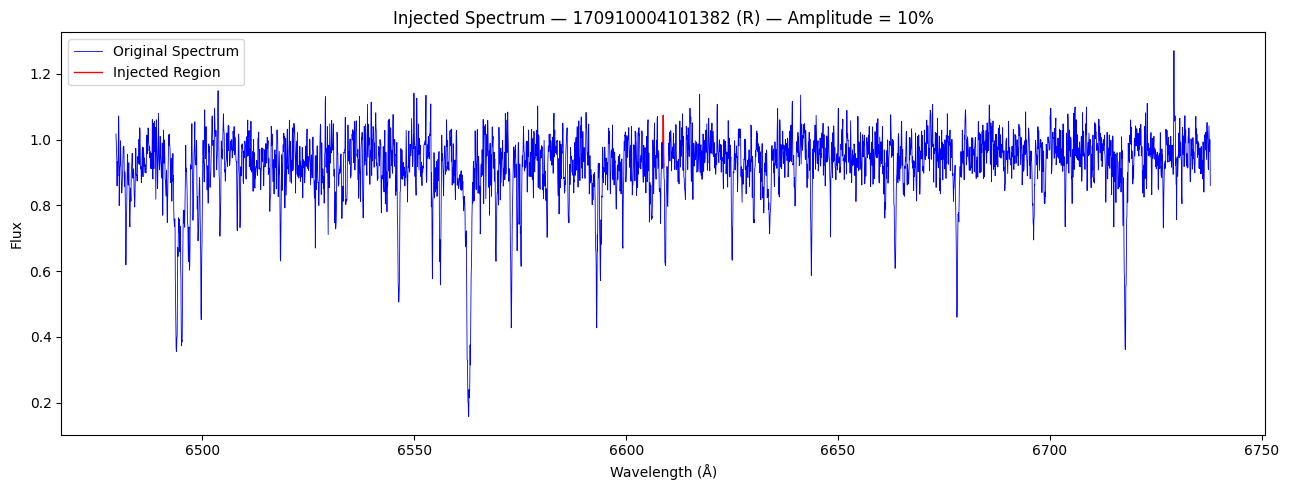

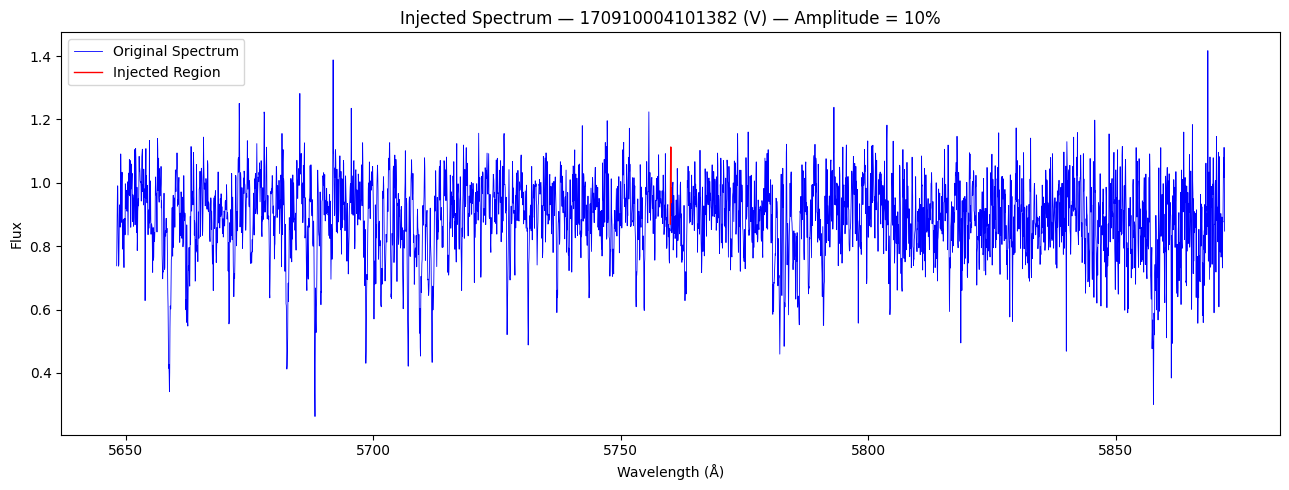

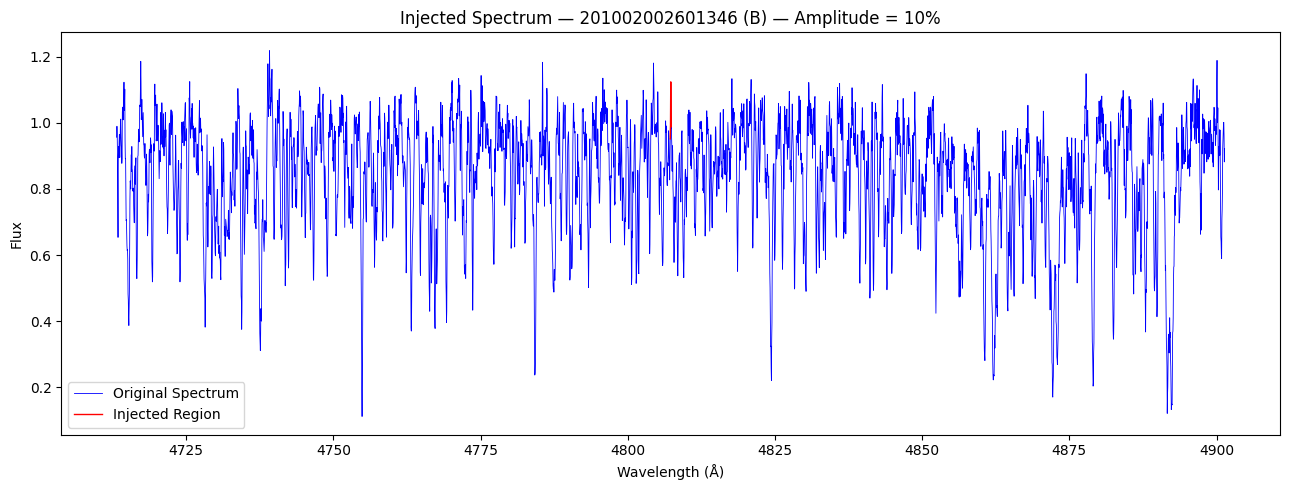

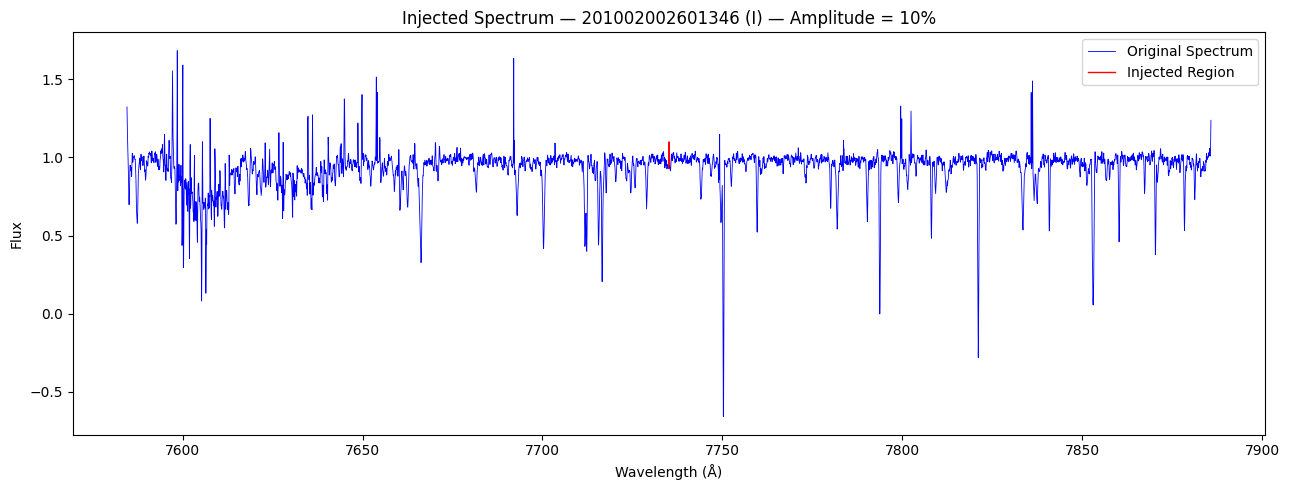

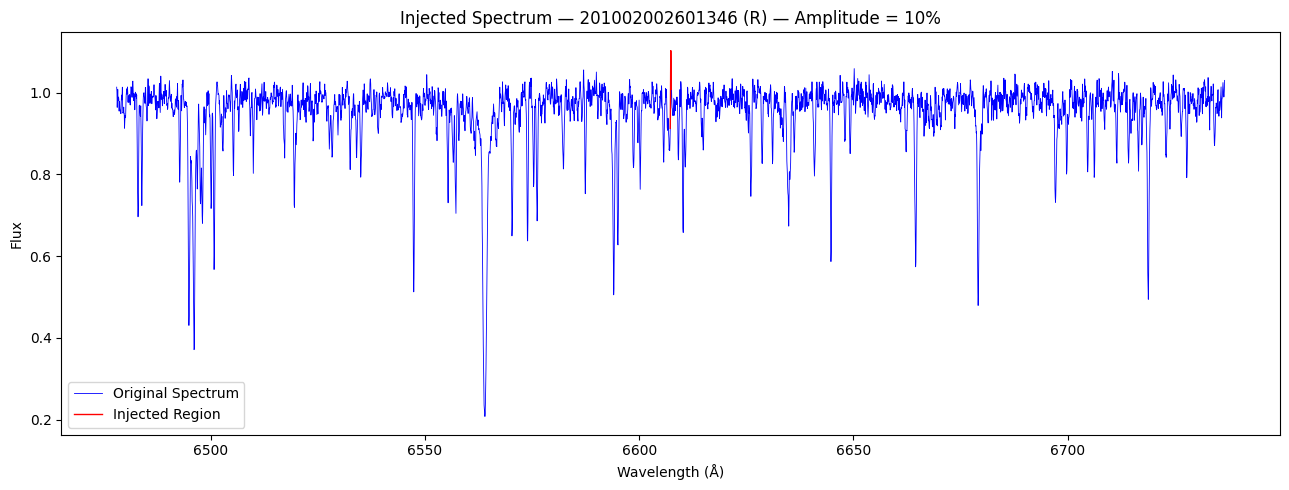

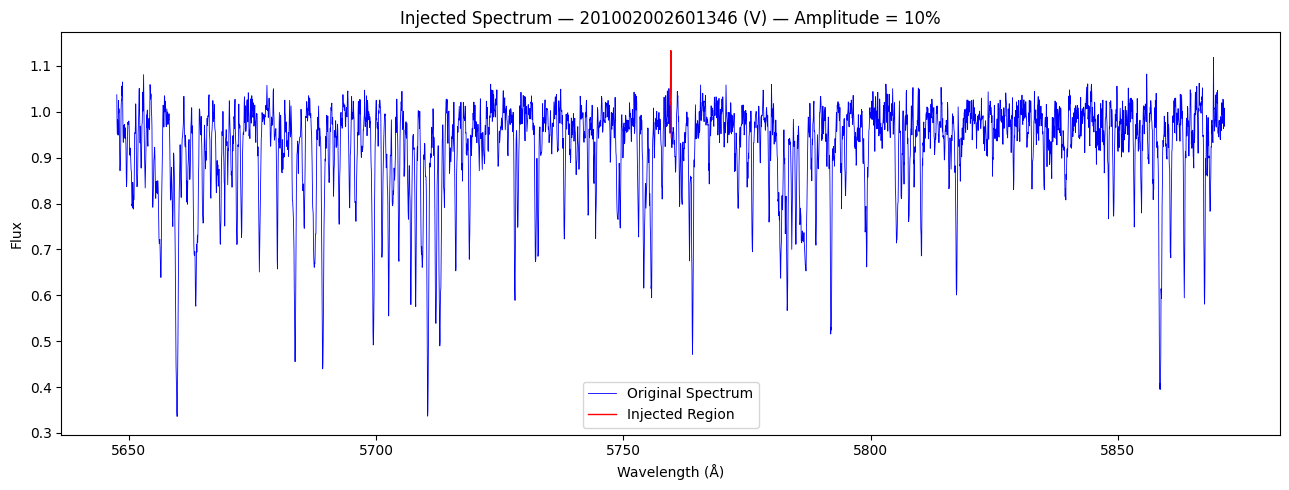

In [24]:
filters = ['B', 'V', 'R', 'I']
folder = "/datax/scratch/emmay/galah_spectra"
results = {}

filenames = sorted(os.listdir(folder))
filenames = [f for f in filenames if f.endswith(".fits")]

for file in filenames:
    parts = file.replace(".fits", "").split("_")
    if len(parts) != 2:
        continue
    obj_id, filt = parts

    try:
        wavelength, flux_injected = inject_and_plot_laser(
            obj_id, filt, folder=folder,
            laser_amp_percent=10,  # change this value as needed
            plot=True
        )
        results[(obj_id, filt)] = (wavelength, flux_injected)
    except Exception as e:
        print(f"Failed on {file}: {e}")
